## 4.5 RNN

### RNN
* Recurrent Neural Network, 순환 신경망
* 과거의 행위가 다음 판단에 영향을 미치는 경우
* 고정 데이터가 아닌 순서가 있는 데이터
    * 예) 우와! 참 재밌네 vs 망할 참 재밌네!
* 구글 번역 서비스
    * Seq2Seq 신경망 모델
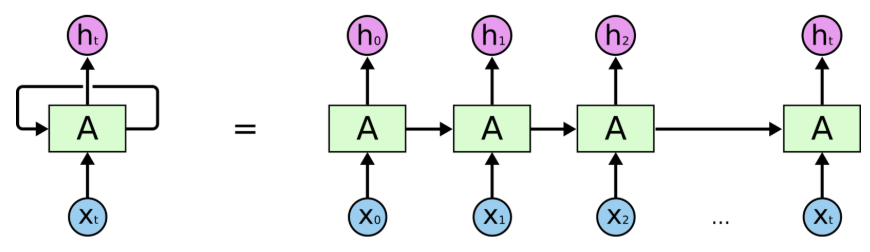

### 순환 신경망
* 시퀀스 데이터 처리할 수 있는 방법
    * RNN
    * 1D Convnet
* 주요 사례
    * 문서 분류, 시계열 분류
    * 감성분석
* 특징
    * 이전 상태 유지
    ```python
    state = 0
    for input in inputs:
        outout, state = rnn_cell(input, state)
    ```
*  RNN 구조 유형
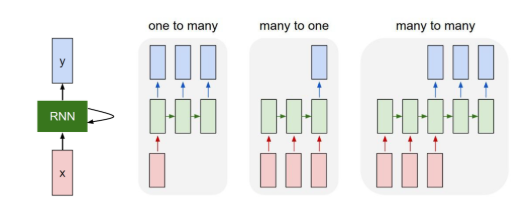
* RNN 개선
    * LSTM(Long Short Term Memory)
    * GRU

### Vanilla RNN
* 상태는 한개의 히든 벡터 H 로 구성
* $h_t = fw(h_{t-1}, x_t)$
    * $h_t = tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$
    * $ y_t = W_{hy}h_t + b_y $
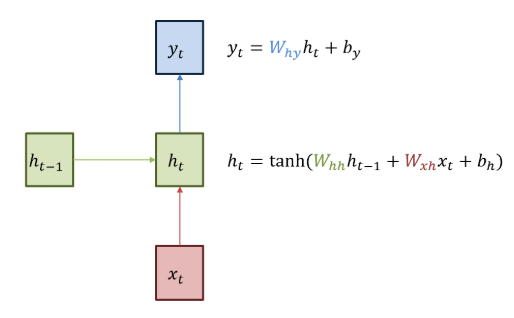
* 학습할 변수들
    * $W_{hx}$, $W_{hh}$, $b_h$
    * $W_{hy}$, $b_y$

### Vanilla RNN Graph
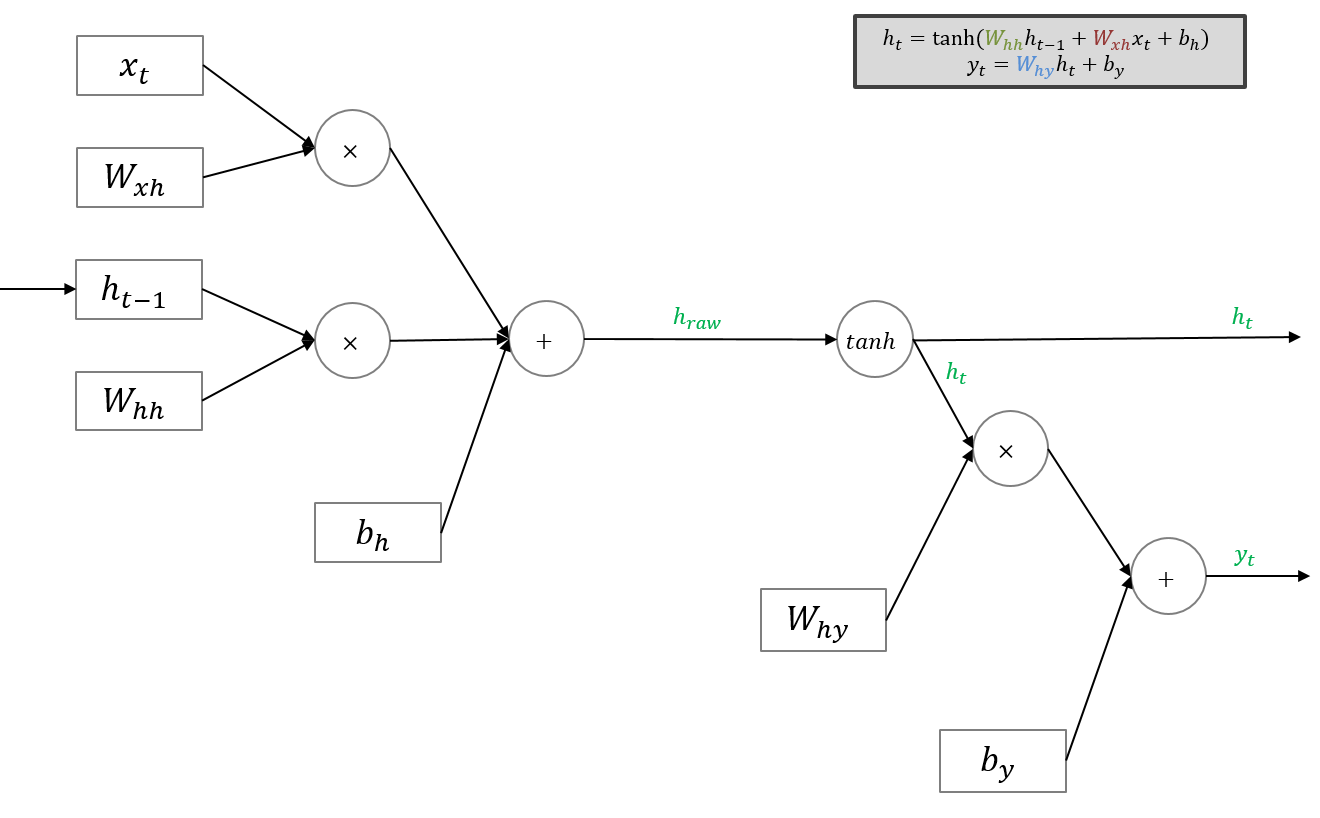

### Vanila RNN 실습
* RNN 구조를 직접 만들어 다음 글자 예측 실습
    * 입력 : "hihell"
    * 출력 : "ihello"
    * many to many
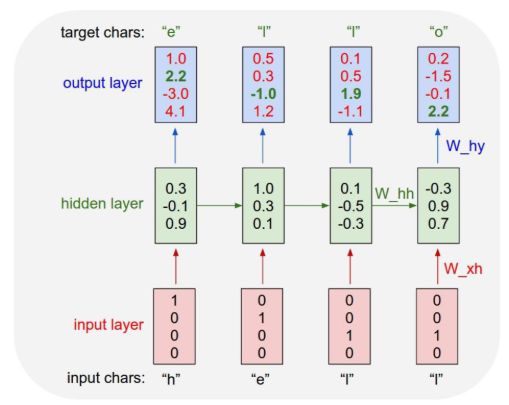

#### 입출력 데이타 준비

In [1]:
import tensorflow as tf
import numpy as np

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)


#### hidden state 준비

In [2]:
X = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="input" )
Y = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="output")

initializer= tf.glorot_uniform_initializer()
Wx = tf.Variable(initializer([n_class, hidden_size]), name="Wx" )
Wh = tf.Variable(initializer([hidden_size, hidden_size]), name="Wh" )
bh = tf.Variable(initializer([hidden_size]), name="bias_h" )

Instructions for updating:
Colocations handled automatically by placer.


#### hidden state 연산

In [3]:
def rnn_step(previous_hidden_state, x):
    current_hidden_state = tf.tanh(
        tf.matmul(previous_hidden_state, Wh) + 
        tf.matmul(x, Wx) + bh)
    return current_hidden_state


X_ = tf.transpose(X, perm=[1, 0, 2])
all_hidden_states = tf.scan(rnn_step, X_, name='states')#, initializer=init_hidden)

#### 출력 연산

In [4]:
Wy = tf.Variable(tf.truncated_normal([hidden_size, n_class], mean=0, stddev=0.01))
by = tf.Variable(tf.truncated_normal([n_class], mean=0, stddev=0.01))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by

all_outputs = tf.map_fn(get_linear_layer, all_hidden_states)

#### 신경망 학습

In [6]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=all_outputs, labels=Y))

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
prediction = tf.argmax(all_outputs, axis=2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_epoch = 500
    for step in range(n_epoch):
        sess.run([ train_step], feed_dict={X:x_enc, Y:y_enc})
        if (step+1) % 20 == 0:
            if step+ 1== n_epoch :
                ao = sess.run(all_outputs, feed_dict={X:x_enc})
                print(ao)
            cost, p = sess.run([cross_entropy, prediction], feed_dict={X:x_enc, Y:y_enc})
            print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(p), [dic2idx[i] for i in np.squeeze(p)]))

step:19, cost:1.5622097253799438, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:39, cost:1.5116010904312134, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:59, cost:1.4602197408676147, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:79, cost:1.4093422889709473, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:99, cost:1.359113097190857, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:119, cost:1.3091453313827515, predict:[2 0 1 1 1 1], str:['i', 'h', 'l', 'l', 'l', 'l']
step:139, cost:1.2592612504959106, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:159, cost:1.2095156908035278, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:179, cost:1.1601762771606445, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:199, cost:1.111865520477295, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:219, cost:1.0652700662612915, predict:[2 0 3 1 1 1], str:['i', 'h', 'e',

### TF RNN API
* `cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)`
    * RNN 구현을 위해 필요한 변수 선언 및 구조 제공
    * `hidden_size` : output, state size
* `outputs, states = tf.nn.dynamic_rnn(cell, X, dtype)`
    * rnn_cell을 전달 받아 반복(tf.scan()) 연산해서 output과 state 계산

In [18]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

x_data = np.array([[[1,2,3,4],
                    [5,6,7,8]]], dtype=np.float32) #(1,2,4) : (batch, time_step, depth)
print(x_data.shape)

hidden_size = 2
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)
print(cell.output_size, cell.state_size)
outputs, states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
output_, states_ = sess.run([outputs, states])
sess.close()
print(output_, states_)


(1, 2, 4)
2 2
[[[ 0.24207196  0.9973034 ]
  [-0.7008234   0.9999829 ]]] [[-0.7008234  0.9999829]]


#### TF RNN API로 "hi hello" 구현

In [37]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)


In [38]:
X = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="input" )
Y = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="output")

cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

initializer= tf.glorot_uniform_initializer()
Wy = tf.Variable(initializer([hidden_size, n_class]))
by = tf.Variable(initializer([n_class]))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by

all_outputs = tf.map_fn(get_linear_layer, outputs)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=all_outputs, labels=Y))

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
prediction = tf.argmax(all_outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_epoch = 500
    for step in range(n_epoch):
        sess.run([ train_step], feed_dict={X:x_enc, Y:y_enc})
        if (step+1) % 20 == 0:
            if step+ 1== n_epoch :
                ao = sess.run(all_outputs, feed_dict={X:x_enc})
                print(ao)
            cost, p = sess.run([cross_entropy, prediction], feed_dict={X:x_enc, Y:y_enc})
            print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(p), [dic2idx[i] for i in np.squeeze(p)]))                 

step:19, cost:1.6352006196975708, predict:[4 4 0 4 3 0], str:['o', 'o', 'h', 'o', 'e', 'h']
step:39, cost:1.551277756690979, predict:[4 0 0 4 3 0], str:['o', 'h', 'h', 'o', 'e', 'h']
step:59, cost:1.4730669260025024, predict:[4 0 2 4 3 4], str:['o', 'h', 'i', 'o', 'e', 'o']
step:79, cost:1.401114821434021, predict:[4 0 2 4 3 4], str:['o', 'h', 'i', 'o', 'e', 'o']
step:99, cost:1.3348385095596313, predict:[2 0 2 4 3 4], str:['i', 'h', 'i', 'o', 'e', 'o']
step:119, cost:1.273011565208435, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:139, cost:1.2145699262619019, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:159, cost:1.1587098836898804, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:179, cost:1.1048619747161865, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:199, cost:1.05260169506073, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:219, cost:1.001578688621521, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l'

## LSTM
* Long Short-Term Memory Unit
* Hochreiter(1997) 제안, RNN 변형 
* 자연어 처리 분야 딥러닝 기법 중 가장 활발히 사용
* RNN의 맨 뒤에서 맨 앞의 정보를 기억하지 못하는 특성 보완
* RNN의 Hidden state에 cell-state를 추가
* 오차의 그라디언트가 시간을 거슬러 잘 흘러갈 수 있다.
* 1000단계가 넘는 Backpropagation 과정에서 오차 값 유지
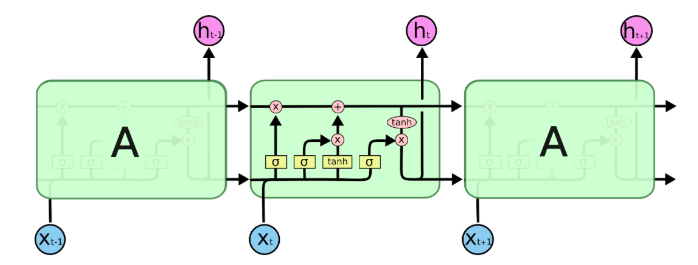

* Hidden Layer를 4개의 계층으로 구성
    * Cell State : 이전 정보를 다음 단계로 전달, 3가지 게이트에 의해 전달 여부 결정
    * Forget Gate : 기존 Cell State에서 어떠한 정보를 지울 지 결정
    * Input Gate : Cell State에 저장할 새로운 정보를 결정
    * Output Gate : Cell State 값을 다음 상태로 출력할 지 결정

### GRUCell
* Gated Recurrent Units
* 2014 뉴욕대 조경현 교수 제안
* LSTM의 변형, 더 간단한 구조
* 게이트 된 순환 유닛(Gate Recurrent Unit)
* 잊기와 입력 게이트들을 하나의 단일 Update 게이트로 통합
* 셀 상태와 숨겨진 상태 통합
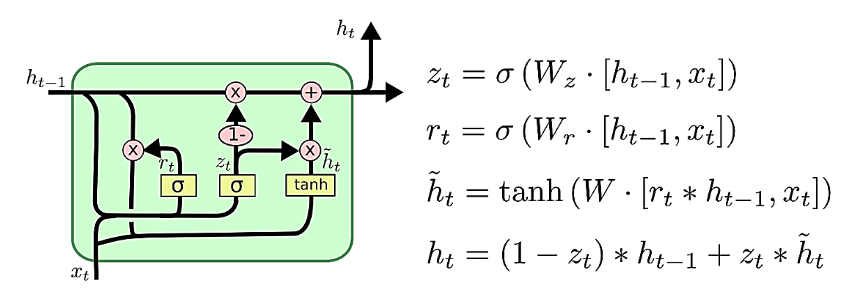

### LSTM/GRU를 이용한 "hihello" 실습
* `tf.nn.rnn_cell.BasicLSTMCell()`
* `tf.nn.rnn_cell.GRUCell()`

In [45]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

X = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="input" )
Y = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="output")

############# Cell Selecte ##############################
cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
#cell = tf.nn.rnn_cell.GRUCell(hidden_size)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

initializer= tf.glorot_uniform_initializer()
Wy = tf.Variable(initializer([hidden_size, n_class]))
by = tf.Variable(initializer([n_class]))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by

all_outputs = tf.map_fn(get_linear_layer, outputs)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=all_outputs, labels=Y))

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
prediction = tf.argmax(all_outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_epoch = 1000
    for step in range(n_epoch):
        sess.run([ train_step], feed_dict={X:x_enc, Y:y_enc})
        if (step+1) % 100 == 0:
            if step+ 1== n_epoch :
                ao = sess.run(all_outputs, feed_dict={X:x_enc})
                print(ao)
            cost, p = sess.run([cross_entropy, prediction], feed_dict={X:x_enc, Y:y_enc})
            print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(p), [dic2idx[i] for i in np.squeeze(p)]))                 

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)
step:99, cost:1.513102412223816, predict:[2 0 1 4 4 4], str:['i', 'h', 'l', 'o', 'o', 'o']
step:199, cost:1.2572771310806274, predict:[1 1 1 1 1 4], str:['l', 'l', 'l', 'l', 'l', 'o']
step:299, cost:1.0543793439865112, predict:[1 1 1 1 1 4], str:['l', 'l', 'l', 'l', 'l', 'o']
step:399, cost:0.8837220072746277, predict:[2 0 3 1 1 4], str:['i', 'h', 'e', 'l', 'l', 'o']
step:499, cost:0.7439799308776855, predict:[2 0 3 1 1 4], str:['i', 'h', 'e', 'l', 'l', 'o']
step:599, cost:0.6213607788085938, predict:[2 0 3 1 1 4], str:['i', 'h', 'e', 'l', 'l', 'o']
step:699, cost:0.4923560321331024, predict:[

In [3]:
# Lab 12 RNN
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
tf.set_random_seed(777)  # reproducibility

idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hello: hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3

y_data = [[1, 0, 2, 3, 3, 4]]    # ihello

num_classes = 5
input_dim = 5  # one-hot size
hidden_size = 5  # output from the LSTM. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 6  # |ihello| == 6
learning_rate = 0.1

X = tf.placeholder(
    tf.float32, [None, sequence_length, input_dim])  # X one-hot
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label

cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(
    cell, X, initial_state=initial_state, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b
outputs = tf.contrib.layers.fully_connected(
    inputs=X_for_fc, num_outputs=num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        l, _ = sess.run([loss, train], feed_dict={X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_one_hot})
        if i%5 == 0:
            print(i, "loss:", l, "prediction: ", result, "true Y: ", y_data)

            # print char using dic
            result_str = [idx2char[c] for c in np.squeeze(result)]
            print("\tPrediction str: ", ''.join(result_str))

0 loss: 1.6078762 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
5 loss: 1.140437 prediction:  [[1 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  illlll
10 loss: 0.5427577 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
15 loss: 0.13267992 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
20 loss: 0.026444651 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
25 loss: 0.008979983 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
30 loss: 0.0041195056 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
35 loss: 0.0024560052 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
40 loss: 0.0017534182 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
45 loss: 0.001378979 prediction:  [[1 0 2 3 3 4]] true Y:  [[1

### tf.keras API 사용 'hihello' 예제 실습

In [71]:
import tensorflow as tf

keras = tf.keras

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
print(dic)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM((hidden_size), input_shape=(n_time_steps, n_class), return_sequences=True))
model.add(keras.layers.Dense(hidden_size))
model.add(keras.layers.Activation('softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

n_epochs = 500
model.fit(x_enc, np.reshape(y_idx, (1,6,1)), epochs=n_epochs)

preds = model.predict(x_enc, verbose=0)
print(preds, np.squeeze(np.argmax(preds, axis=2)))
print([voca[i] for i in np.squeeze(np.argmax(preds, axis=2))])

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)
Epoch 1/500
1/1 [==============================] - 1s 841ms/sample - loss: 1.6758 - acc: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.6744 - acc: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.6729 - acc: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.6715 - acc: 0.0000e+00
Epoch 5/500
1/1 [==============================] - 0s 19ms/sample - loss: 1.6702 - acc: 0.0000e+00
Epoch 6/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.6688 - acc: 0.0000e+00
Epoch

1/1 [==============================] - 0s 15ms/sample - loss: 1.5820 - acc: 0.3333
Epoch 82/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.5809 - acc: 0.3333
Epoch 83/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.5798 - acc: 0.3333
Epoch 84/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.5787 - acc: 0.3333
Epoch 85/500
1/1 [==============================] - 0s 13ms/sample - loss: 1.5776 - acc: 0.3333
Epoch 86/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.5765 - acc: 0.3333
Epoch 87/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.5754 - acc: 0.3333
Epoch 88/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.5743 - acc: 0.3333
Epoch 89/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.5731 - acc: 0.3333
Epoch 90/500
1/1 [==============================] - 0s 13ms/sample - loss: 1.5720 - acc: 0.3333
Epoch 91/500
1/1 [==============================] - 0

Epoch 166/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.4573 - acc: 0.3333
Epoch 167/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.4553 - acc: 0.3333
Epoch 168/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.4533 - acc: 0.3333
Epoch 169/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4513 - acc: 0.3333
Epoch 170/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4492 - acc: 0.3333
Epoch 171/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4472 - acc: 0.3333
Epoch 172/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4451 - acc: 0.3333
Epoch 173/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.4430 - acc: 0.3333
Epoch 174/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.4409 - acc: 0.3333
Epoch 175/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.4388 - acc: 0.3333
Epoch 176/500
1/1 [===========

Epoch 251/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.2626 - acc: 0.3333
Epoch 252/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.2602 - acc: 0.3333
Epoch 253/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.2578 - acc: 0.3333
Epoch 254/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.2553 - acc: 0.3333
Epoch 255/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.2529 - acc: 0.3333
Epoch 256/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.2505 - acc: 0.3333
Epoch 257/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.2481 - acc: 0.3333
Epoch 258/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.2456 - acc: 0.3333
Epoch 259/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.2432 - acc: 0.3333
Epoch 260/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.2407 - acc: 0.3333
Epoch 261/500
1/1 [===========

Epoch 336/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.0476 - acc: 0.6667
Epoch 337/500
1/1 [==============================] - 0s 13ms/sample - loss: 1.0453 - acc: 0.6667
Epoch 338/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.0430 - acc: 0.6667
Epoch 339/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.0406 - acc: 0.6667
Epoch 340/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.0383 - acc: 0.6667
Epoch 341/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.0360 - acc: 0.6667
Epoch 342/500
1/1 [==============================] - 0s 19ms/sample - loss: 1.0338 - acc: 0.6667
Epoch 343/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.0315 - acc: 0.6667
Epoch 344/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.0292 - acc: 0.6667
Epoch 345/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.0269 - acc: 0.6667
Epoch 346/500
1/1 [===========

Epoch 421/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8613 - acc: 0.8333
Epoch 422/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8593 - acc: 0.8333
Epoch 423/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8573 - acc: 0.8333
Epoch 424/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8553 - acc: 0.8333
Epoch 425/500
1/1 [==============================] - 0s 13ms/sample - loss: 0.8533 - acc: 0.8333
Epoch 426/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8513 - acc: 0.8333
Epoch 427/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8492 - acc: 0.8333
Epoch 428/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8472 - acc: 0.8333
Epoch 429/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8452 - acc: 0.8333
Epoch 430/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8432 - acc: 0.8333
Epoch 431/500
1/1 [===========

### MNIST 이미지
* many to one
* 28 * 28 숫자 이미지 : 시퀀스로서의 이미지
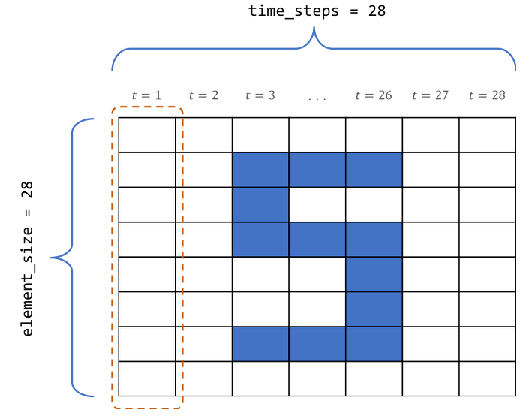

In [1]:
import tensorflow as tf

tf.reset_default_graph()

element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128
# Where to save TensorBoard model summaries

# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    # Train set
    train_x = train_x.astype('float32') / 255.
    train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)
    # Test set
    test_x = test_x.astype('float32') / 255.
    test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)
    return (train_x, train_y), (test_x, test_y)
# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()
dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))
dataset = dataset.shuffle(100000).repeat().batch(batch_size)
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()


_inputs = tf.placeholder(tf.float32, 
                           shape=[None, time_steps, element_size], 
                           name='inputs')
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='labels')

cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
#cell = tf.nn.rnn_cell.GRUCell(hidden_size)
outputs, states = tf.nn.dynamic_rnn(cell, _inputs, dtype=tf.float32)

Wl = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], 
                                           mean=0, stddev=.01))
bl = tf.Variable(tf.truncated_normal([num_classes], 
                                           mean=0, stddev=.01))

# 상태 벡터에 linear layer 적용
def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wl) + bl

last_output = outputs[:,-1,:]
final_output =get_linear_layer(last_output)

cross_entropy = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_output, labels=y))

learning_rate = 0.001
#train_step = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(final_output, 1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

test_data = test_x[:batch_size].reshape([-1, time_steps, element_size])
test_label = test_y[:batch_size]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())


    for step in range(10000):
        batch_x, batch_y = sess.run(next_batch)
        _ = sess.run([train_step], 
                            feed_dict={_inputs:batch_x['image'], y:batch_y})          

        if (step+1) % 1000 == 0:
            acc, loss = sess.run([accuracy, cross_entropy], 
                                feed_dict={_inputs:batch_x['image'], y:batch_y})
            print("Iter: %04d\t" % (step+1), 
                    "MiniBatch Loss: {:.6f}\t".format(loss),
                    "Training Acc={:.5f}".format(acc))
        if (step+1) % 100 == 0:
            acc = sess.run([accuracy], 
                            feed_dict={_inputs: test_data, 
                                    y: test_label})

    test_acc = sess.run(accuracy, feed_dict={_inputs: test_data,
                                            y: test_label})
    print("Test Accuracy:", test_acc)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Iter: 1000	 MiniBatch Loss: 0.041357	 Training Acc=100.00000
Iter: 2000	 MiniBatch Loss: 0.069895	 Training Acc=99.21875
Iter: 3000	 MiniBatch Loss: 0.038573	 Training Acc=99.21875
Iter: 4000	 MiniBatch Loss: 0.019762	 Training Acc=99.21875
Iter: 5000	 MiniBatch Loss: 0.025940	 Training Acc=99.21875
Iter: 6000	 MiniBatch Loss: 0.079453	 Training Acc=97.65625
Iter: 7000	 MiniBatch Loss: 0.014170	 Training Acc=99.21875
Iter: 8000	 MiniBatch Loss: 0.004988	 Training Acc=100.00000
Iter: 9000	 MiniBatch Loss: 0.006360	 Training Acc=100.00000
Iter: 10000	 MiniBatch Loss: 0.001283	 Training Acc=100.00000
Test Accuracy: 96.09375




## 텍스트 데이터 다루기
* 텍스트가 가장 흔한 시퀀스 데이타
* 비전이 픽셀에 대한 패턴인식
* 자연어처리는 단어, 문장, 문단에 대한 패턴인식
* 입력데이타는 텍스트 원본일 수 없어서 텍스트 벡터화 필요
    * 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환
    * 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환
    * 텍스트에서 단어나 문자의 n-그램을 추출하여 그것을 하나의 벡터로 변환
        * n-gram: 문장에서 이웃한 N개의 문자
        * n-gram은 연속된 단어나 문자의 그룹으로 텍스트에서 단어나 문자를 하나씩 이동하면서 추출
            * "The cat sat on the mat"
                * 2-gram : "The", "The cat", "cat", "cat sat", "sat", "sat on", "on", "on the", "the", "the mat", "mat"
    * 어떻게 변환하든 이것을 토큰이라한다.
    * 토큰에 수치형 벡터 연결
        * 원핫 인코딩
        * 토큰 임베딩

### 단어와 문자의 원핫 인코딩
* 토큰을 벡터로 변환하는 가장 일반적인 방법
* 모든 단어에 고유한 인텍스 부여, 인텍스를 원핫 인코딩
    * 단어가 아니라 문자를 대상으로 해도 됨
* keras 원핫인코딩 유틸
    * keras.preprocessing.text.Tokenizer
    

### 단어 임베딩 사용하기
* 원핫 인코딩은 희소배열인데다가 단어나 문자수가 많아 지면 차원이 너무 높다.
    * 밀집, 저차원이 필요
        * 데이터로 학습
            * 예)남성/여성, 복수/단수, 부정/긍정
        * 사전 훈련 단어 임베딩 사용

#### 훈련된 단어 임베딩 사용하기
* Web3vec
* GloVe 

#### LSTM을 이용한 문장 자동 생성기 예제
* 박경리 토지 다운로드
    * 국립국어원 : https://ithub.korean.go.kr/user/total/database/corpusView.do?boardSeq=2&articleSeq=2081&boardGb=T&isInsUpd=&boardType=CORPUS
    * ./data/BEXX004.txt
* 필요 라이브러리
    * `!pip install beautifulsoup4`
    * `!pip install konlpy`

In [5]:
!pip install beautifulsoup4
!pip install konlpy

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import codecs
from bs4 import BeautifulSoup
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random, sys

fp = codecs.open("./data/BEXX0004.txt", "r", encoding="utf-16")
soup = BeautifulSoup(fp, "html.parser")
body = soup.select_one("body")
text = body.getText() + " "
print('코퍼스의 길이: ', len(text))
# 문자를 하나하나 읽어 들이고 ID 붙이기
chars = sorted(list(set(text)))
print('사용되고 있는 문자의 수:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars)) # 문자 → ID
indices_char = dict((i, c) for i, c in enumerate(chars)) # ID → 문자
# 텍스트를 maxlen개의 문자로 자르고 다음에 오는 문자 등록하기
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('학습할 구문의 수:', len(sentences))
print('텍스트를 ID 벡터로 변환합니다...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
# 모델 구축하기(LSTM)
print('모델을 구축합니다...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
# 후보를 배열에서 꺼내기
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)
# 학습시키고 텍스트 생성하기 반복
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('반복 =', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1) # 
    # 임의의 시작 텍스트 선택하기
    start_index = random.randint(0, len(text) - maxlen - 1)
    # 다양한 다양성의 문장 생성
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('--- 다양성 = ', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('--- 시드 = "' + sentence + '"')
        sys.stdout.write(generated)
        # 시드를 기반으로 텍스트 자동 생성
        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.
            # 다음에 올 문자를 예측하기
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            # 출력하기
            generated += next_char
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

Using TensorFlow backend.


코퍼스의 길이:  360490
사용되고 있는 문자의 수: 1888
학습할 구문의 수: 120157
텍스트를 ID 벡터로 변환합니다...
모델을 구축합니다...

--------------------------------------------------
반복 = 1
Instructions for updating:
Use tf.cast instead.


/Users/rainer/Dropbox/work/ml_dl/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
120157/120157 [==============================] - 408s 3ms/step - loss: 3.7887

--- 다양성 =  0.2
--- 시드 = " 아배 놔두고 시집온 내가 직일년이지"
 아배 놔두고 시집온 내가 직일년이지 않았다. 그러나 그러나 다가 있었다. 그러나 그러나 하지 않았다. 그러나 다가 있는 것이 있는 것이 있는 것이 비음이 있었다. 그런 말이 있었다. 그러나 하고 있는 것이다. 그러나 대하고 있는 것이다. 그러나 그러나 다가 것이 있는 것이 생각이 있었다. 그러나 그러나 하고 있는 것이 그 말이 있었다. 그런 말이 있었다. 그러나 그러나 다가 한다.
"그런 말이 있다. 그러나 그러나 다가 하는 것이 있는 것이 나이 있었다. 그러나 내가 있다. 그러나 하고 있는 것이다. 그러나 다 말이 있는 것이다. 그러나 다 하다. 그러나  기다. 그러나 이 있는 것이 아니다.
"그런 말이 있다. 그러나 그러나 그러나 지마는 그런 것이 있었다. 그러나 그러나 다가 하지 않았다. 그러나 하고 있는 것이 있는 것이 ."
"그런 

--- 다양성 =  0.5
--- 시드 = " 아배 놔두고 시집온 내가 직일년이지"
 아배 놔두고 시집온 내가 직일년이지. 어매 가 있는 것이다. 자기 동생이 알아왔다.
"그렇다."
"그 말이 있는 것이다. 바람을 막어 있다.
"오."
"그라는 사람이 있는 것이 않았다. 조선을 적어서 게 있었다. 그런 지도 그렇지 않았다. 그렇다. 그런 것이 ……"
"그러나 자들 하고 있는 것이 하다. 그러나 고, 고 자신 신지 않았을 것이 만나 있었다. 그러나 이는 것이 없었다. 그런 일이 되었다.
"이 집 사람이 있었다. 그러나 들어서 생각이 주어 있다.
"그것이 내가 다 하지 않았다. 연해서 나가지 않았다. 웃는 것이 ."
"나기는 아니지요."
"그런 말이 있지."
"그런 말이요."
"그러나 비여 사람이 알아오지 않았다. 내 말이 있었다. 그러나 모르지 않았이 동생은 고개한 사람이 오나 있는

KeyboardInterrupt: 

#### 챗봇 실습 예제
* Eliza online demo : http://www.masswerk.at/elizabot/
    * 환자 중심 상담 이론 기반
    * 상대의 말을 반복하는 단순한 기능
    * 영어만 가능

##### 필요 라이브러리
* `!pip install beautifulsoup4`
* `!pip install konlpy`
    * 윈도즈: https://needjarvis.tistory.com/224
    * 맥 : 
        * `export MACOSX_DEPLOYMENT_TARGET=10.10`
        * `CFLAGS="-stdlib=libc++" pip install konlpy`


In [3]:
!pip install beautifulsoup4

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
# 맥인 경우만 실행
!CFLAGS="-stdlib=libc++" pip install jpype1
!export MACOSX_DEPLOYMENT_TARGET=10.10
!CFLAGS='-stdlib=libc++' pip install konlpy

#!pip install konlpy

In [6]:
import codecs
from bs4 import BeautifulSoup
import urllib.request
from konlpy.tag import Twitter
import os, re, json, random
dict_file = "chatbot-data.json"
dic = {}
twitter = Twitter()
# 딕셔너리에 단어 등록하기 --- (※1)
def register_dic(words):
    global dic
    if len(words) == 0: return
    tmp = ["@"]
    for i in words:
        word = i[0]
        if word == "" or word == "\r\n" or word == "\n": continue
        tmp.append(word)
        if len(tmp) < 3: continue
        if len(tmp) > 3: tmp = tmp[1:]
        set_word3(dic, tmp)
        if word == "." or word == "?":
            tmp = ["@"]
            continue
    # 딕셔너리가 변경될 때마다 저장하기
    json.dump(dic, open(dict_file,"w", encoding="utf-8"))
# 딕셔너리에 글 등록하기
def set_word3(dic, s3):
    w1, w2, w3 = s3
    if not w1 in dic: dic[w1] = {}
    if not w2 in dic[w1]: dic[w1][w2] = {}
    if not w3 in dic[w1][w2]: dic[w1][w2][w3] = 0
    dic[w1][w2][w3] += 1
# 문장 만들기 --- (※2)
def make_sentence(head):
    if not head in dic: return ""
    ret = []
    if head != "@": ret.append(head)        
    top = dic[head]
    w1 = word_choice(top)
    w2 = word_choice(top[w1])
    ret.append(w1)
    ret.append(w2)
    while True:
        if w1 in dic and w2 in dic[w1]:
            w3 = word_choice(dic[w1][w2])
        else:
            w3 = ""
        ret.append(w3)
        if w3 == "." or w3 == "？ " or w3 == "": break
        w1, w2 = w2, w3
    ret = "".join(ret)
    # 띄어쓰기
    params = urllib.parse.urlencode({
        "_callback": "",
        "q": ret
    })
    # 네이버 맞춤법 검사기를 사용합니다.
    try:
        data = urllib.request.urlopen("https://m.search.naver.com/p/csearch/dcontent/spellchecker.nhn?" + params)
        data = data.read().decode("utf-8")[1:-2]
        data = json.loads(data)
        data = data["message"]["result"]["html"]
        data = soup = BeautifulSoup(data, "html.parser").getText()
        # 리턴
    except :
        data = ret
    return data
def word_choice(sel):
    keys = sel.keys()
    return random.choice(list(keys))
# 챗봇 응답 만들기 --- (※3)
def make_reply(text):
    # 단어 학습시키기
    if not text[-1] in [".", "?"]: text += "."
    words = twitter.pos(text)
    register_dic(words)
    # 사전에 단어가 있다면 그것을 기반으로 문장 만들기
    for word in words:
        face = word[0]
        if face in dic: return make_sentence(face)
    return make_sentence("@")
# 딕셔너리가 있다면 읽어 들이기
if os.path.exists(dict_file):
    dic = json.load(open(dict_file,"r"))
    print("dictionary loaded.")
else:
    print("no dictionary. 챗봇 훈련이 필요해요.")

c:\python36\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
c:\python36\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


dictionary loaded.


In [ ]:
print("대화를 종료하시려면 'exit'를 입력하세요.")
while True:
    txt = input("Me:")
    if txt == "exit":
        print("Bye~")
        break
    reply = make_reply(txt)
    print("Bot:%s"%reply)

대화를 종료하시려면 'exit'를 입력하세요.
Me:안녕?
Bot:안녕?
Me:뭐해?
Bot:뭐좋아하니?
Me:맥주
Bot:맥주도마시구.
Me:소주가 더 좋은데..
Bot:소주가더좋은데..
Me:안주는 뭐 먹지?
Bot:안주는뭐먹지?
Me:치킨
Bot:치킨좋아해.
Me:족발은?
Bot:족발은?
Me:보쌈도 좋지
Bot:보쌈도좋지.
Me:그렇구나..
Bot:알아나도.
Me:뭘 알아?
Bot:뭘먹을까?
Me:치킨
Bot:치킨먹고싶다.
Me:그렇구나.
Bot:족발은?
